# Project 101
### PARTE 2 - Modelado

### Contenido
- [Introducción](#intro)
- [Data preparation](#dataprep)
- [Descomposicion de la serie](#desc)
- [Modelado](#modelos)

    - [**1. Modelos Estadísticos Clásicos**](#1)
        - [Dicky Fuller Test](#1.1)
        - [Autocorrelacion y Autocorrelacion Parcial](#1.2)
        - [SARIMAX model](#1.3)
        
    - [**2. Modelos ML**](#2) 
        - [Random Forest](#1.2)
        - [MA model](#1.3)

    - [**3. Modelos Redes Neuronales**](#2) 
        - [Neural Prophet (Facebook)](#1.3)



        - 

    - [Resultados](#resultados)


De acuerdo con los resultados obtenidos en el EDA y la validación realizada con el equipo de ventas, importacion y exportacion, concluimos en los principales motivos que deben ser modelados. Como las condiciones economicas y politicas son tan cambiantes con el fin de adaptarse a las nuevas necesidades de los clientes, Raiconet con frecuencia lanza o relanza nuevos motivos realizando cambios en las rutas, agentes y proveedores. Por ello, en el plazo del analisis de los ultimos 5 años, muchos de los motivos ya no son utilizados. 

Los prinicipales motivos a predecir son: 

__Impo:__
-   528 USA FLAT
-   544 UPS MERCOSUR
-   571 Geobox Flat
-   597 EUROPA UPS
-   550 ORIENTE UPS
-   600 Courier Oriente Flat Wish
-   598 China Latin
 
__Expo:__
 - Exporta Simple (P.A.)
 - CARGA AEREA EXPO PREPAID
 - CARGA AEREA EXPO - Q (Servicios expo Quick)
 - 4-Expo - Fedex Economy	
 - 6-Expo-UPS Express

#### Bibliografia

https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

Clave: 
https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

https://bookdown.org/JakeEsprabens/431-Time-Series/modelling-time-series.html

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

posibles metricas a usar 
https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7#:~:text=Currently%2C%20the%20most%20popular%20metrics,are%20MAE%2C%20RMSE%20and%20AIC.&text=To%20briefly%20summarize%2C%20both%20MAE,impact%20of%20the%20large%20errors.

https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

## Description

- modelos autoregresivos clasicos→ arima
- modelos basados en arboles
- regresion lineal
- exponential smooth
- red neuronal

⇒ en los clásicos se puede agregar informacion temporal, como numero de la semana del ano, numero de la semana del mes

→ variables exógenas agregarlas despues

→ transformaciones seno y coseno al año ⇒ para patrones estacionales

—> poner el numero de la semana del mes→ cuantos días tiene el mes→ primer dia del mes de esa semana

→ feriados → hollidays libreria → feriados poner pais

→ como es la serie de tiempo en el mes → uno encima del otro normalizado hay una tendencia, hacer la prediccion mensual y despues llevarla a la semanal —>lineal, modelo que te distrbuya en la semana

ACF ⇒ autocorrelograma 

⇒ lags, seasonality,

ACP ⇒ autocorrelograma parcial

⇒ autocorrelacion

ML Flow

⇒ transformada de Furier, descomposicion de frecuencias⇒ la serie original los datos, te da una composicion por esa serie, peaks donde hay valores que se repiten

⇒ aplicar para todos⇒ escribir esta tiene este valor y esta otra no

→ Darts, Nixla, (tres librerias, statmodel, tecnicas estaddisticas clasicas, ML (aroles y lineales), modelos de deeplearning

→ Darts tiene un mix de modelos adentro

Backtesting permite hacer random testing, elegis el numero de semanas que queres predecir, depende del largo de la serie, 25 para tets, testeo solo para 5. 

Backtesting 80%

LugonTS: amazon, modelo clasico se llama DeepAR (red recurrente, mucho mas maduro), buen baseline para AR en los modelos de deep learing

__Importamos las librerias a usar__

In [195]:
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import seaborn as sns  
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.arima_model import ARIMA, ARMA


import time
time.clock = time.time

from sklearn.metrics import mean_squared_error, mean_absolute_error



__Funciones útiles__

In [196]:
def crear_dataset(df, motivo): 
    df= df[['Guias_Fecha', 'Motivo', 'Guias_Peso']]
    df['Guias_Fecha']= pd.to_datetime(df['Guias_Fecha'])
    df= df[df['Motivo']==motivo]
    df.rename(columns = {'Guias_Peso': 'y'}, inplace = True)
    df.drop(columns='Motivo', inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns= 'index', inplace= True)
    #agrupamos por semana => porque las entradas estan separadas, asi q nos quedamos con el total de kilos por fecha
    df= df.groupby(pd.Grouper(key='Guias_Fecha', axis=0, freq='W')).sum()
    df['ds']= df.index
    df = df.reset_index(drop=True)
    df= df[['ds', 'y']]
    return df

### Data Preparation <a id='dataprep'></a>

Vamos a agrupar las entradas por fecha para tener el volumen total de kilos por semana. Luego vamos a crear un df para cada motivo y entrenar los modelos.

__Importamos los datos a usar__

In [197]:
df_guias_impo= pd.read_csv('Data/Guias Impo.csv')
df_guias_expo= pd.read_csv('Data/Guias Expo.csv')

Top 7 servicios de IMPO

In [198]:
df_impo_1= crear_dataset(df_guias_impo,'USA FLAT')
df_impo_1.to_csv('Data/Modelado/impo 1 - USA FLAT.csv')

df_impo_2= crear_dataset(df_guias_impo, 'ORIENTE UPS')
df_impo_2.to_csv('Data/Modelado/impo 2 - ORIENTE UPS.csv')

df_impo_3= crear_dataset(df_guias_impo, 'CHINA LATIN LOGISTIC  CO via UPS/FEDEX')
df_impo_3.to_csv('Data/Modelado/impo 3 - CHINA LATIN LOGISTIC.csv')

df_impo_4= crear_dataset(df_guias_impo, 'EUROPA UPS')
df_impo_4.to_csv('Data/Modelado/impo 4 - EUROPA UPS.csv')

df_impo_5= crear_dataset(df_guias_impo, 'Courier Oriente FLAT Wish/Latin logistic')
df_impo_5.to_csv('Data/Modelado/impo 5 - Courier Oriente FLAT Wish.csv')

df_impo_6= crear_dataset(df_guias_impo, 'Impo Geobox Flat ')
df_impo_6.to_csv('Data/Modelado/impo 6 - Impo Geobox Flat.csv')

df_impo_7= crear_dataset(df_guias_impo, 'UPS MERCOSUR')
df_impo_7.to_csv('Data/Modelado/impo 7 - UPS MERCOSUR.csv')

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\2769424762.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\2769424762.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\2769424762.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\i

Top 5 servicios de EXPO

In [199]:
df_expo_1= crear_dataset(df_guias_expo, 'Exporta Simple - Puerta-Aeropuerto')
df_expo_1.to_csv('Data/Modelado/expo 1 - Exporta Simple - Puerta-Aeropuerto.csv')

df_expo_2= crear_dataset(df_guias_expo, 'CARGA AEREA EXPO PREPAID')
df_expo_2.to_csv('Data/Modelado/expo 2 - CARGA AEREA EXPO PREPAID.csv')

df_expo_3= crear_dataset(df_guias_expo, 'CARGA AEREA EXPO - Q')
df_expo_3.to_csv('Data/Modelado/expo 3 - CARGA AEREA EXPO - Q.csv')

df_expo_4= crear_dataset(df_guias_expo, '4-Expo - Fedex Economy')
df_expo_4.to_csv('Data/Modelado/expo 4 - 4-Expo - Fedex Economy.csv')


C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\2769424762.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\2769424762.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\2769424762.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\i

De esta forma, obtenemos por cada motivo un dataframe con dos columnas: 'ds' la fecha que permite identificar la semana y 'y' el total de kilos transportados para esa semana. Tambien, crearemos un diccionario para poder identificar mas adelante a que sigla corresponde cada motivo, por cuestiones practicas fueron resumidos en el tipo de servicio y un numero.

In [200]:
df_impo_1.head()

,ds,y
0,2019-01-06,1950.0
1,2019-01-13,2402.0
2,2019-01-20,2782.0
3,2019-01-27,3263.0
4,2019-02-03,3843.0


Contrui un diccionario que permite mapear el nombre del dataframe designado con el nombre del motivo, para permitir un analisis mas prolijo y no perder referencia sobre el motivo sobre el que estare trabajando

In [201]:
lista_df= ['df_impo_1', 'df_impo_2', 'df_impo_3', 'df_impo_4', 'df_impo_5','df_impo_6', 'df_impo_7',
           'df_expo_1', 'df_expo_2', 'df_expo_3', 'df_expo_4']
nombres_motivos= ['528 USA FLAT', '550 ORIENTE UPS','598 CHINA LATIN LOGISTIC', '597 EUROPA UPS', '600 Flat Wish', '571 Geobox Flat', 'UPS MERCOSUR', 
            'Exporta Simple', 'CARGA AEREA EXPO PREPAID', 'CARGA AEREA EXPO - Q', '4-Expo - Fedex Economy']
dic_num_motivos= {lista_df[i]: nombres_motivos[i] for i in range(len(lista_df))}

### Descomposición de la serie <a id='desc'></a>

Para esta sección previo a comenzar a modelar estudiaré la composición de las series de tiempo para cada motivo, de que forma se autocorrelacionan, si existen patrones intrínsicos o factores externos que pueden influir en el posterior entrenamineto del modelo. 

##### Distribución Semanal por Motivo

Observando las distribuciones para cada motivo seleccionado, observamos como poseen cualidades y patrones muy diferentes entre si. Ademas algunos motivos son recientes por lo que no hay datos previos al 2022 como en el caso de Geobox Flat, o incluso hay otros motivos como por ejemplo 598 y 600 ambos de la sede de China que presentan semanas en donde el volumen es cero, estos estancamientos se deben en gran medida en que son motivos complementarios y deberian presentar patrones y comportamientos similares. 

Cada motivo posee su particularidad y esta expuesto a distintos eventos externos como pueden ser medidas que afecten directamente al servicio como medidas aduaneras para la exportacion o para la importacion, o incluso como representan rutas especificas sus variaciones pueden responder a la demanda de los clientes por estas rutas o las interrupciones que pueden haber en las mismas. 

Cada una de las series presentadas representan diversos factores que influyen en su comportamiento, para ello en esta seccion intentare descomponer y comprender que factores realmente inciden y si estos son comun para los motivos seleccionados. 

In [202]:
lista_dataframe= [df_impo_1, df_impo_2, df_impo_3, df_impo_4, df_impo_5,df_impo_6, df_impo_7,
           df_expo_1, df_expo_2, df_expo_3, df_expo_4]

n= 0

for df in lista_dataframe: 
    
    a= lista_df[n]
    b= dic_num_motivos[a]
    
    fig = px.line(df, x='ds', y='y', title=f"Volumen de Kilos Semanal {a[3:]} <br><sup>{b}</sup>")

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
        )
    
    n+=1
    
    fig.show()


### Modelado


Antes de comenzar a evaluar y analizar posibles modelos, determinare las metricas a utilizar y las con las cuales compararemos mas adelante las performance de cada modelo.

Las metricas de evaluacion elegidas para el forecasting son: 

Scale Dependent Metrics: 
- MAE (Mean Absolute Error): Permite una facil interpretacion ya que mide el error promedio en terminos absolutos, es decir nos permite comparar que tan bueno es el modelo en terminos de errores promedio en unidades absolutas de kilos. Ademas, a diferencia del RMSE no penaliza los outliers. 

- AIC: mide la perdida de informacion y penaliza modelos complejos. La idea principal detras de la metrica es que un modelo con menor cantidad de parametros es mejor, lo que nos permitira medir la capacidad del modelo en predecir sin hacer overfitting. 
    
- MAPE: es una medida facil de interpretar ya que permite identificar en terminos de porcentaje que tan bueno es el modelo en predecir y que porcentaje de error posee. Aunque la media sea susceptible al efecto de valores atipicos aun asi es una buena metrica para comparar modelos con el mismo set de datos. 

In [203]:
# creamos una tabla donde guardar los resultados de los modelos que corremos 
comparison_tbl = pd.DataFrame(columns = ['Serie',
                                        'Modelo',
                                        'MAE',
                                        'RMSE', 
                                        'MAPE',
                                        'AIC',
                                        'Processing Time'])

i_index=[]
i_index = -1

models = []

#### 1. Modelos Estadísticos Clásicos

En esta seccion analizaré y compararé modelos estadísticos clasicos: AR, MA, ARMA y Arima. Por ello antes de comenzar a modelar aplicaremos los test correspondientes de autocorrelacion y autocorrelacion parcial para conocer las caracteristicas de las series y luego poder decidir que modelos estadisticos podrian ser aplicados. 
Como la autocorrelación supone que las series son estacionarias antes de comenzar a analizarlas debemos verificar que lo sean, para ello utilice el ADF (Augmented Dicky-Fuller Test), una vez obtenidas las series estacionarias aplicare los test ACF y PACF, luego para las series no estacionarias las transformare para convertirlas en estacionaria y poder aplicar los test. 

Mas adelante, una vez analizados los resultados, aplicare los modelos de acuerdo a los resultados obtenidos para cada serie. 

Por otro lado, aparte de encontrar patrones en las series los resultados de los test de autocorrelacion no solo aportaran para aplicar los modelos clasicos sino que tambien poseen un impacto practico en modelos de ML y Deep Learning ya que nos permiten tomar decisiones a la hora de modelar y tunear hiperparametros


##### ACF & PACF 

Como la autocorrelacion supone que las series son estacionarias antes de comenzar a analizarlas debemos verificar que lo sean, para ello utilice el ADF (Augmented Dicky-Fuller Test) 

Autocorrelograma

Apart of finding patterns and allowing know your data better ACF has also significant practical impact in predictive data analysis. For instance if you are using deep learning for data prediction you can build more efficient and simpler models (therefore less computation demanding) by ignoring values (creating smaller learning batches) that statistically do not have impact on data.


Autocorrelation analysis is an important step in the Exploratory Data Analysis (EDA) of time series. The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

#### ADF - Augmented Dicky-Fuller 

##### Test de Estacionalidad

ACF and PACF assume stationarity of the underlying time series. Staionarity can be checked by performing an Augmented Dickey-Fuller (ADF) test:

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
[...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. - Machine Learning Mastery: How to Check if Time Series Data is Stationary with Python

If the time series is stationary, continue to the next steps. If the time series is not stationary, try differencing the time series and check its stationarity again.

In [204]:
def check_stationarity(series):
    # Copiado de https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [205]:
n=0
for df in lista_dataframe:
    a= lista_df[n]
    b= dic_num_motivos[a]
    print('.......................................', '\n',f'{a}', '\n', f'{b}', '\n')
    check_stationarity(df['y'])
    n+=1

....................................... 
 df_impo_1 
 528 USA FLAT 

ADF Statistic: -4.304913
p-value: 0.000436
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Stationary
....................................... 
 df_impo_2 
 550 ORIENTE UPS 

ADF Statistic: -2.015910
p-value: 0.279641
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary
....................................... 
 df_impo_3 
 598 CHINA LATIN LOGISTIC 

ADF Statistic: -4.931840
p-value: 0.000030
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
....................................... 
 df_impo_4 
 597 EUROPA UPS 

ADF Statistic: -1.847862
p-value: 0.356971
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary
....................................... 
 df_impo_5 
 600 Flat Wish 

ADF Statistic: -2.697520
p-value: 0.074468
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary
....................................... 
 df_impo_6 
 571 Geobox Flat 

ADF Statistic

Los resultados obtenidos nos indican que con un nivel de confianza al 95% podemos rechazar o no rechazar la hipotesis nula de que la serie es estacionaria. Por ello los resultados obtenidos resaltaran en verde a las que no se puede rechazar la hipotesis nula (son estacionarias) y en rojo a las que no son estacionarias por lo que se rechaza la hipotesis nula.

De esta forma obtenemos que las series que son estacionarias son: 
    
    - Impo 1
    - Impo 3
    - Impo 7
    - Expo 2
    - Expo 4

Por eso a estos motivos cuyas series son estacionarias podremos realizar el analisis de Autocorrelacion (ACF) y Autocorrelacion Parcial (PACF) 



### If the time series is stationary, continue to the next steps. If the time series is not stationary, try differencing the time series and check its stationarity again

In [206]:
series_estacionarias= [df_impo_1, df_impo_3, df_impo_7, df_expo_2, df_expo_4]
series_no_estacionarias= [df_impo_2, df_impo_4, df_impo_5, df_impo_6, df_expo_1, df_expo_3]

Autocorrelation Function (ACF)¶


Correlation between time series with a lagged version of itself. The correlation between the observation at the current time spot and the observations at previous time spots.The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

We will be using the plot_acf function from the statsmodels.graphics.tsaplots library. (See statsmodels.tsa.stattools.acf)

The ACF plot can provide answers to the following questions:

- Is the observed time series white noise / random?

- Is an observation related to an adjacent observation, an observation twice-removed, and so on?

- Can the observed time series be modeled with an MA model? If yes, what is the order?

Partial Autocorrelation Function (PACF)¶

Additional correlation explained by each successive lagged term. The correlation between pbservations at two time spots given that we consider both observations are correlated to observations at other time spots.

The partial autocorrelation at lag k is the autocorrelation between  Xt
  and  Xt−k
  that is not accounted for by lags 1 through  k−1
 .

We will be using the plot_pacf function from the statsmodels.graphics.tsaplots library with the parameter method = "ols" (regression of time series on lags of it and on constant). (See statsmodels.tsa.stattools.pacf)

Sidenote: The default parameter for method is yw (Yule-Walker with sample-size adjustment in denominator for acovf). However, this default value is causing some implausible autocorrelations higher than 1 on the sample data. Therefore, we change the method parameter to one that is not causing this issue. ywmle would also work fine as suggested in this StackExchange post

The PACF plot can provide answers to the following questions:

- Can the observed time series be modeled with an AR model? If yes, what is the order?

Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

The difference between ACF and PACF is the inclusion or exclusion of indirect correlations in the calculation.

Furthermore, you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

#### Series Estacionarias

**Autocorrelacion (ACF) y Autocorrelacion Parcial (PACF)**

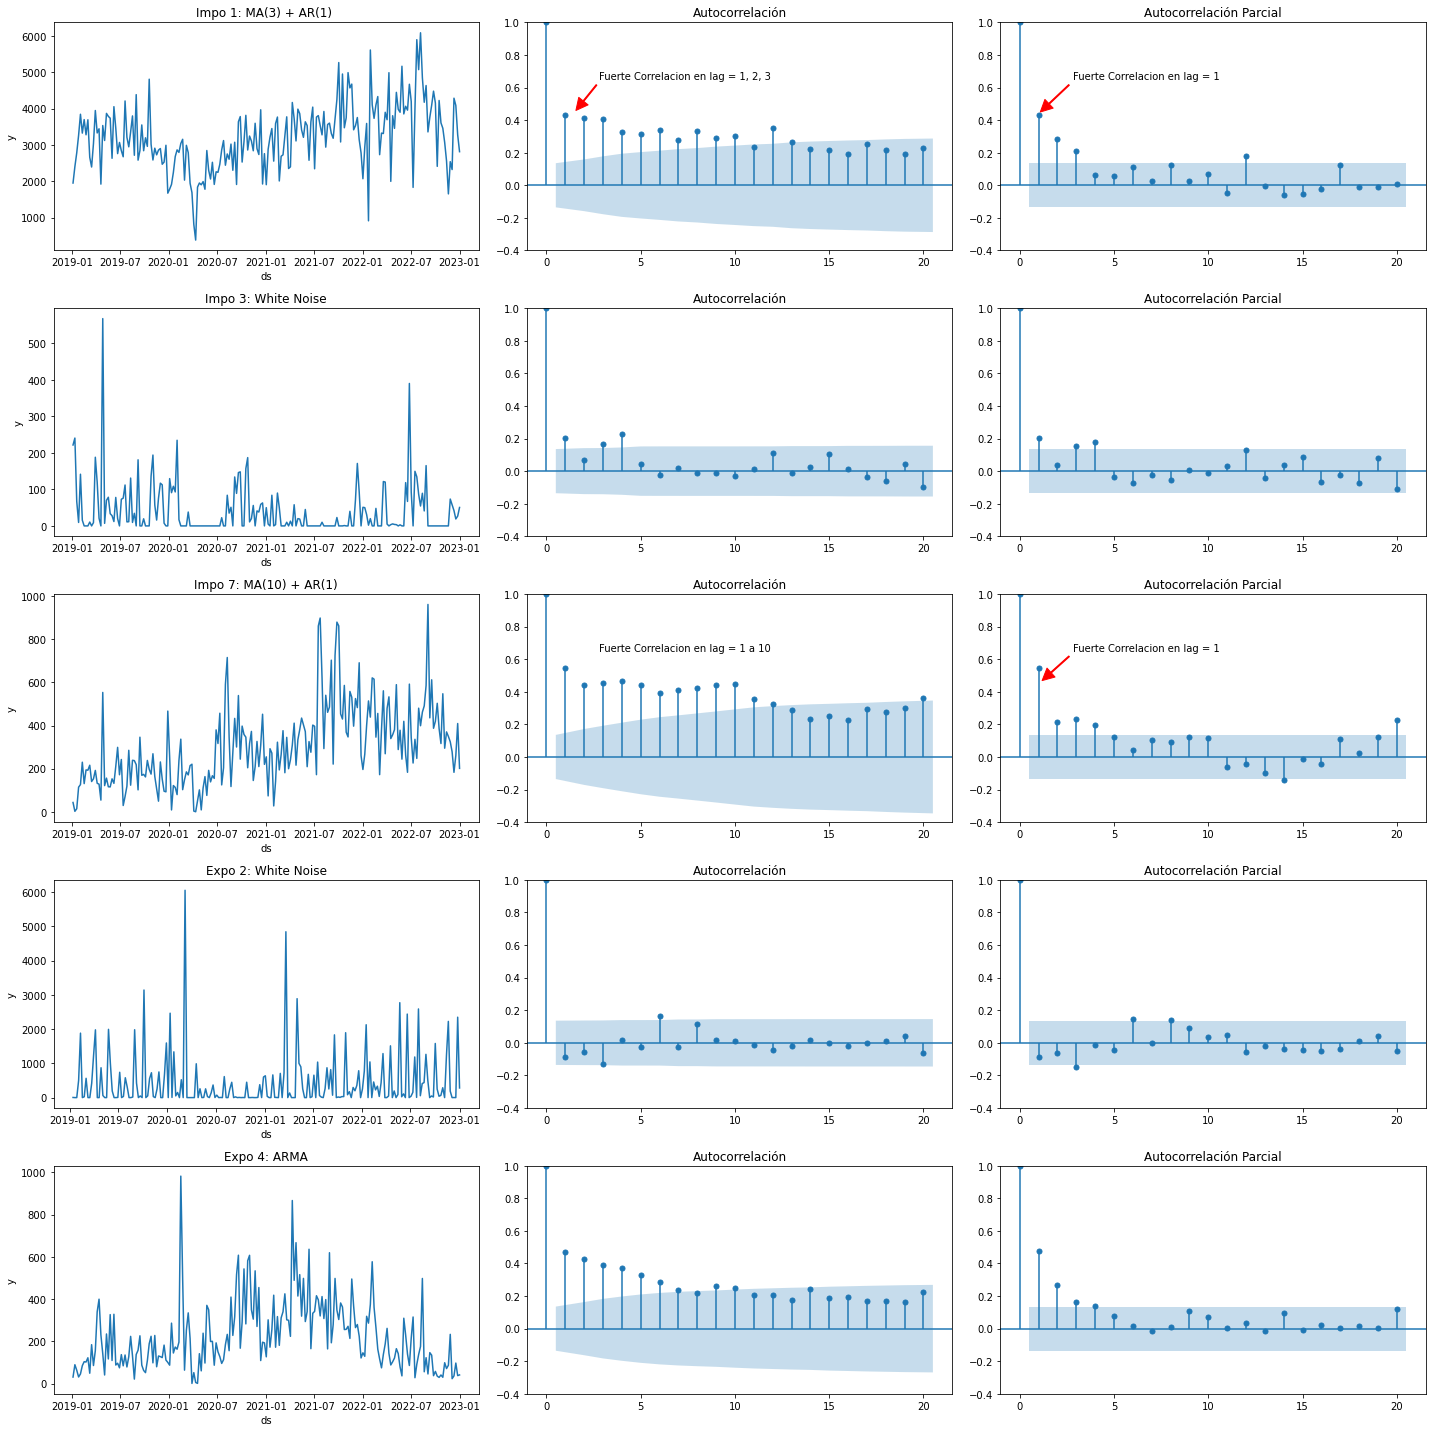

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

width = 20
height = 10
lag_acf = 20
lag_pacf = 20

# Crear la figura
f, ax = plt.subplots(nrows=5, ncols=3, figsize=(width, 2 * height))

##### Impo 1

# Graficar la serie de tiempo
sns.lineplot(x=df_impo_1['ds'], y=df_impo_1['y'], ax=ax[0, 0])
ax[0, 0].set_title('Impo 1: MA(3) + AR(1) ')

# Graficar ACF
plot_acf(df_impo_1['y'], lags=lag_acf, ax=ax[0, 1])
ax[0, 1].set_ylim(-0.4, 1)
ax[0, 1].set_title('Autocorrelación')
ax[0, 1].annotate('Fuerte Correlacion en lag = 1, 2, 3', xy=(1.5, 0.45), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF 
plot_pacf(df_impo_1['y'], lags=lag_pacf, ax=ax[0, 2], method='ols')
ax[0, 2].set_ylim(-0.4, 1)
ax[0, 2].set_title('Autocorrelación Parcial')
ax[0, 2].annotate('Fuerte Correlacion en lag = 1', xy=(1, 0.44), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Impo 3

# Graficar la serie de tiempo para Impo 3
sns.lineplot(x=df_impo_3['ds'], y=df_impo_3['y'], ax=ax[1, 0])
ax[1, 0].set_title('Impo 3: White Noise')  # Ajusta el título según corresponda

# Graficar ACF para Impo 3
plot_acf(df_impo_3['y'], lags=lag_acf, ax=ax[1, 1])
ax[1, 1].set_ylim(-0.4, 1)
ax[1, 1].set_title('Autocorrelación')

# Graficar PACF para Impo 3
plot_pacf(df_impo_3['y'], lags=lag_pacf, ax=ax[1, 2], method='ols')
ax[1, 2].set_ylim(-0.4, 1)
ax[1, 2].set_title('Autocorrelación Parcial')

##### Impo 7

# Graficar la serie de tiempo para Impo 7
sns.lineplot(x=df_impo_7['ds'], y=df_impo_7['y'], ax=ax[2, 0])
ax[2, 0].set_title('Impo 7: MA(10) + AR(1)')  # Ajusta el título según corresponda

# Graficar ACF para Impo 7
plot_acf(df_impo_7['y'], lags=lag_acf, ax=ax[2, 1])
ax[2, 1].set_ylim(-0.4, 1)
ax[2, 1].set_title('Autocorrelación')
ax[2, 1].annotate('Fuerte Correlacion en lag = 1 a 10', xy=(1.1, 0.46), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')

# Graficar PACF para Impo 7
plot_pacf(df_impo_7['y'], lags=lag_pacf, ax=ax[2, 2], method='ols')
ax[2, 2].set_ylim(-0.4, 1)
ax[2, 2].set_title('Autocorrelación Parcial')
ax[2, 2].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0.46), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Expo 2

# Graficar la serie de tiempo para Expo 2
sns.lineplot(x=df_expo_2['ds'], y=df_expo_2['y'], ax=ax[3, 0])
ax[3, 0].set_title('Expo 2: White Noise')  

# Graficar ACF para Expo 2
plot_acf(df_expo_2['y'], lags=lag_acf, ax=ax[3, 1])
ax[3, 1].set_ylim(-0.4, 1)
ax[3, 1].set_title('Autocorrelación')

# Graficar PACF para Expo 2
plot_pacf(df_expo_2['y'], lags=lag_pacf, ax=ax[3, 2], method='ols')
ax[3, 2].set_ylim(-0.4, 1)
ax[3, 2].set_title('Autocorrelación Parcial')

##### Expo 4

# Graficar la serie de tiempo para Expo 4
sns.lineplot(x=df_expo_4['ds'], y=df_expo_4['y'], ax=ax[4, 0])
ax[4, 0].set_title('Expo 4: ARMA')  # Ajusta el título según corresponda

# Graficar ACF para Expo 4
plot_acf(df_expo_4['y'], lags=lag_acf, ax=ax[4, 1])
ax[4, 1].set_ylim(-0.4, 1)
ax[4, 1].set_title('Autocorrelación')

# Graficar PACF para Expo 4
plot_pacf(df_expo_4['y'], lags=lag_pacf, ax=ax[4, 2], method='ols')
ax[4, 2].set_ylim(-0.4, 1)
ax[4, 2].set_title('Autocorrelación Parcial')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()


De acuerdo a los resultados obtenidos para los test de autocorrelacion, y autocorrelacion parcial, podemos definir que tipo de modelo podria utilizarse para cada serie tal como se especifica en los titulos de las serie en los plot. 

Sin embargo, tambien se observa que hay dos series que poseen ruido blanco: impo 3 y expo 2, para estas series mas adelante probaremos aplicar modelos AR, MA, ARMA y ARIMA pero con el fin de comparar resultados ya que de acuerdo a los resultados la serie no es compatible con este tipo de modelos.

A modo de resumen los resultados obtenidos fueron: 

- Impo 1: MA(3), o bien AR(1). 

        Por poseer una fuerte correlacion en los lags 1, 2 y 3 para el test ACF, y por presentar una fuerte correlacion en el lag 1 para el test PACF.


- Impo 3: Ruido Blanco.

        No se presentan correlaciones significativas al 95% de confianza para ninguno de los test. Por lo tanto la serie no presenta autocorrelaciones. 

- Impo 7: MA(10), o bien AR(1). 

        Presenta una fuerte correlacion del lag 1 al 10 siendo en todos los casos mayor a 0.4 en el test ACF, y ademas presenta una fuerte correlacion en el lag 1 para el test PACF.

- Expo 2: Ruido Blanco

        No se presentan correlaciones significativas al 95% de confianza para ninguno de los test. Por lo tanto la serie no presenta autocorrelaciones. 

- Expo 4: ARMA 

        Ya que ambos resultados de los test ACF y PACF presentan una distribucion exponencial, por lo que un modelo ARMA seria el apropiado. 

#### Series No Estacionarias

**Autocorrelacion (ACF) y Autocorrelacion Parcial (PACF)**

Para el caso de las series no estacionarias antes de correr el test de autocorrelacion debemos quitar la tendencia creciente o decreciente para convertirlas en series estacionarias. Luego aplicaremos como hicimos en la seccion anterior los test ACF y PACF a las nuevas series sin tendencia.

Para el caso de las series no estacionarias antes de correr el test de autocorrelacion debemos quitar la tendencia creciente o decreciente para convertirlas en series estacionarias. Luego aplicaremos como hicimos en la seccion anterior los test ACF y PACF a las nuevas series sin tendencia. 

In [208]:
def crear_diff(df): 
    
    df['y_diff']= df['y'].diff().fillna(0)
    print(check_stationarity(df['y_diff']))
    
    return df

In [209]:
df_impo_2= crear_diff(df_impo_2)
df_impo_4= crear_diff(df_impo_4)
df_impo_5= crear_diff(df_impo_5)
df_impo_6= crear_diff(df_impo_6)
df_expo_1= crear_diff(df_expo_1)
df_expo_3= crear_diff(df_expo_3)

ADF Statistic: -12.890491
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None
ADF Statistic: -9.735220
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None
ADF Statistic: -10.877838
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None
ADF Statistic: -12.447145
p-value: 0.000000
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
Stationary
None
ADF Statistic: -6.603343
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Stationary
None
ADF Statistic: -18.818721
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None


Tal como se observa en las gráficas debajo, obtenemos un nuevo conjunto de series que nos permite analizar autocorrelaciones y autocorrelaciones parciales para motivos con series no estacionarias. Como se observa, la serie azul corresponde a la serie con tendencia y la linea naranja a la nueva serie obtenida. A partir de esta realizaremos los test ACF y PACF.

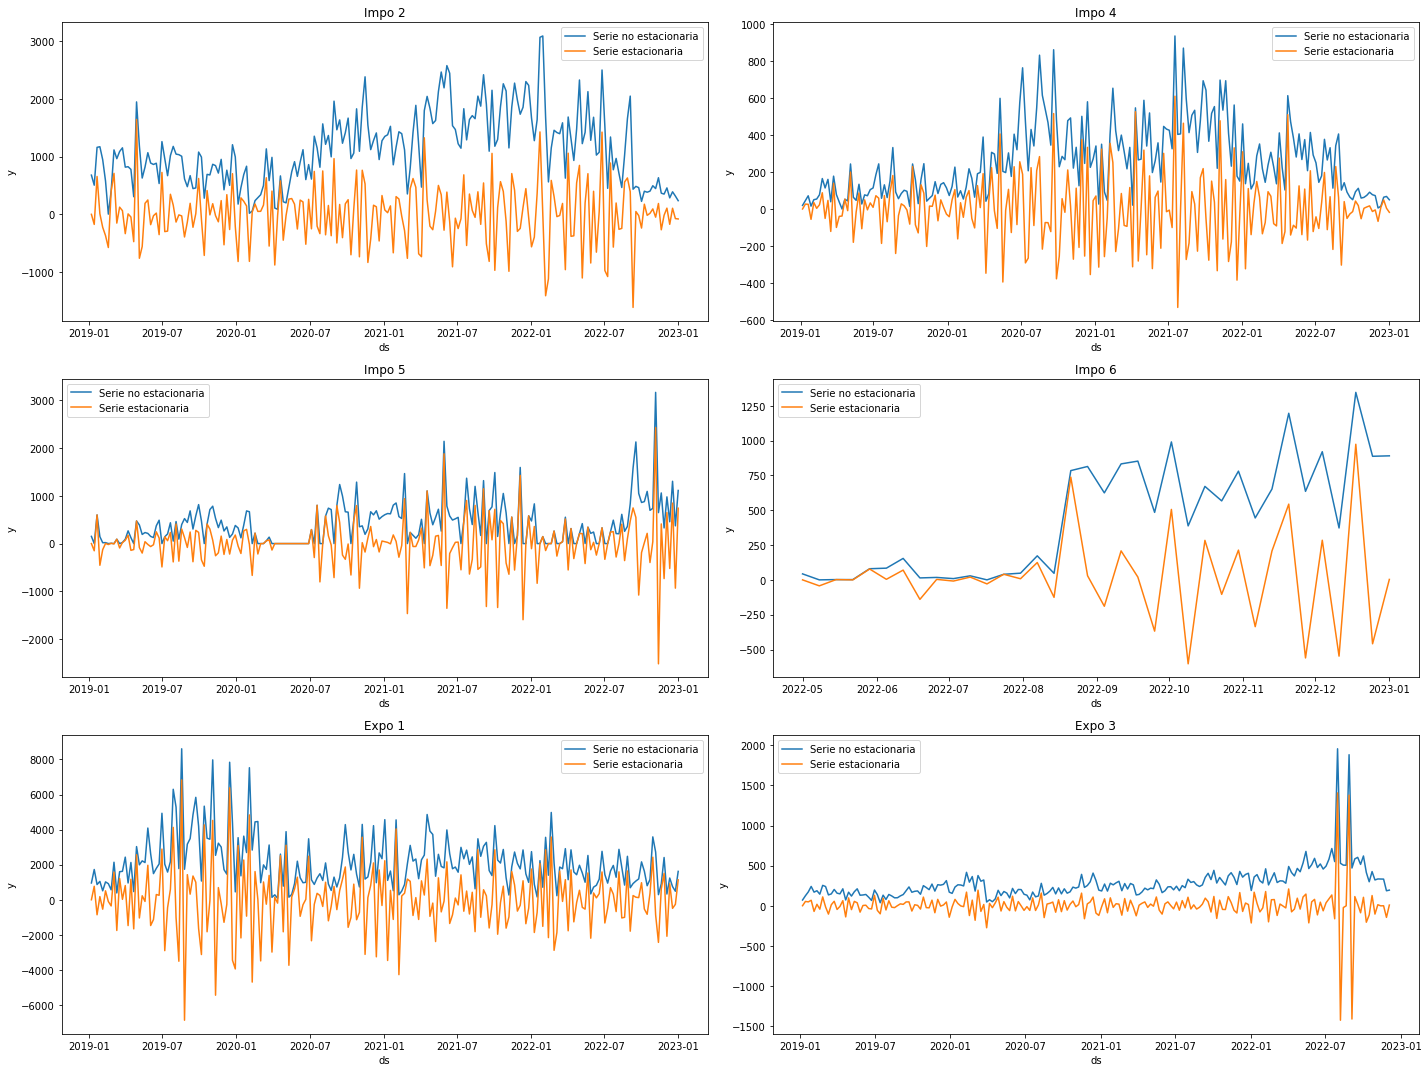

In [210]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

datasets = [
    (df_impo_2, 'Impo 2'), (df_impo_4, 'Impo 4'),
    (df_impo_5, 'Impo 5'), (df_impo_6, 'Impo 6'),
    (df_expo_1, 'Expo 1'), (df_expo_3, 'Expo 3')
]

for i, (data, title) in enumerate(datasets):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    
    sns.lineplot(data=data, x='ds', y='y', ax=ax, label='Serie no estacionaria')
    sns.lineplot(data=data, x='ds', y='y_diff', ax=ax, label='Serie estacionaria')
    
    ax.set_title(f'{title}')
    ax.legend() 

plt.tight_layout()


plt.show()


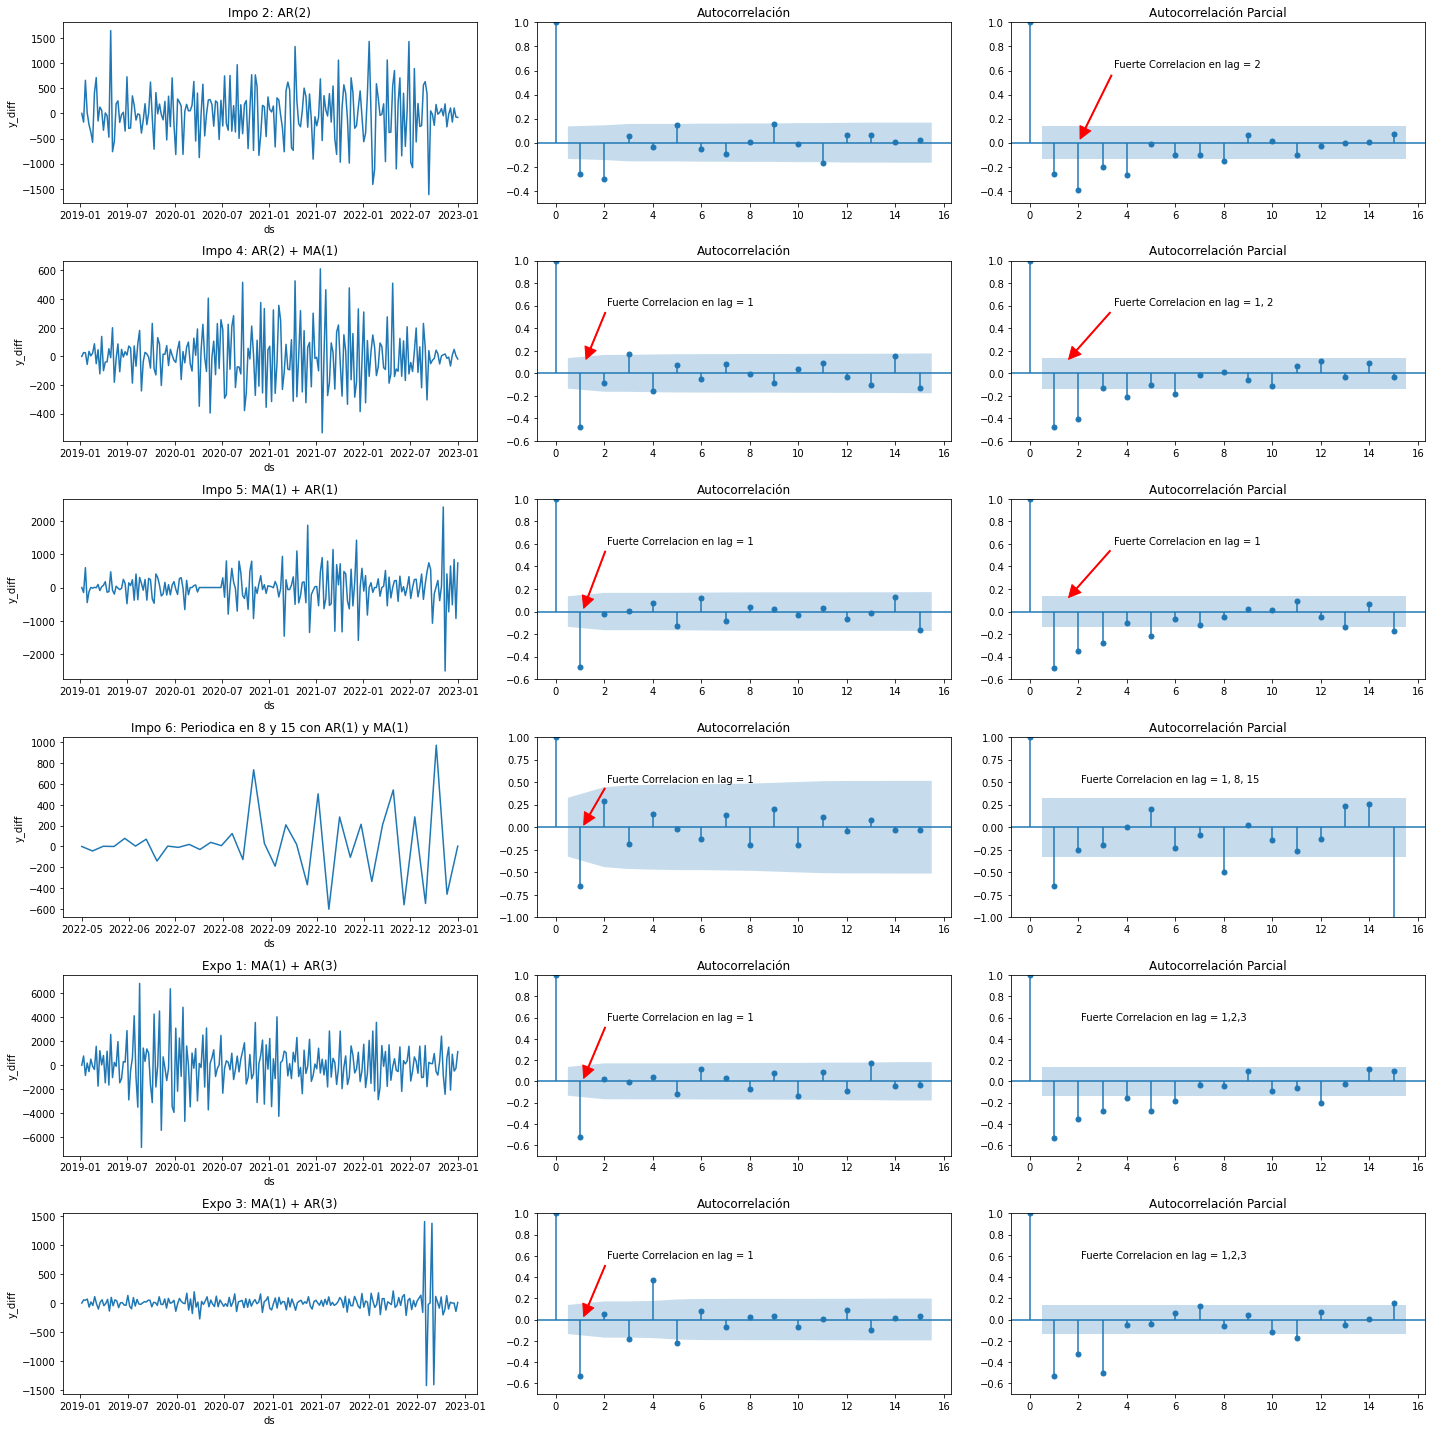

In [211]:

width = 20
height = 10
lag_acf = 15
lag_pacf = 15

f, ax = plt.subplots(nrows=6, ncols=3, figsize=(width, 2 * height))

##### Impo 2

# Graficar la serie de tiempo
sns.lineplot(x=df_impo_2['ds'], y=df_impo_2['y_diff'], ax=ax[0, 0])
ax[0, 0].set_title('Impo 2: AR(2)')

# Graficar ACF
plot_acf(df_impo_2['y_diff'], lags=lag_acf, ax=ax[0, 1])
ax[0, 1].set_ylim(-0.5, 1)
ax[0, 1].set_title('Autocorrelación')

# Graficar PACF 
plot_pacf(df_impo_2['y_diff'], lags=lag_pacf, ax=ax[0, 2], method='ols')
ax[0, 2].set_ylim(-0.5, 1)
ax[0, 2].set_title('Autocorrelación Parcial')
ax[0, 2].annotate('Fuerte Correlacion en lag = 2', xy=(2,- 0), xycoords='data',
               xytext=(0.25,0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Impo 4

# Graficar la serie de tiempo para Impo 3
sns.lineplot(x=df_impo_4['ds'], y=df_impo_4['y_diff'], ax=ax[1, 0])
ax[1, 0].set_title('Impo 4: AR(2) + MA(1)')  # Ajusta el título según corresponda

# Graficar ACF para Impo 4
plot_acf(df_impo_4['y_diff'], lags=lag_acf, ax=ax[1, 1])
ax[1, 1].set_ylim(-0.6, 1)
ax[1, 1].set_title('Autocorrelación')
ax[1, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.2, 0.1), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Impo 4
plot_pacf(df_impo_4['y_diff'], lags=lag_pacf, ax=ax[1, 2], method='ols')
ax[1, 2].set_ylim(-0.6, 1)
ax[1, 2].set_title('Autocorrelación Parcial')
ax[1, 2].annotate('Fuerte Correlacion en lag = 1, 2', xy=(1.5,0.1), xycoords='data',
               xytext=(0.25,0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Impo 5

# Graficar la serie de tiempo para Impo 5
sns.lineplot(x=df_impo_5['ds'], y=df_impo_5['y_diff'], ax=ax[2, 0])
ax[2, 0].set_title('Impo 5: MA(1) + AR(1)')  # Ajusta el título según corresponda

# Graficar ACF para Impo 5
plot_acf(df_impo_5['y_diff'], lags=lag_acf, ax=ax[2, 1])
ax[2, 1].set_ylim(-0.6, 1)
ax[2, 1].set_title('Autocorrelación')
ax[2, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Impo 5
plot_pacf(df_impo_5['y_diff'], lags=lag_pacf, ax=ax[2, 2], method='ols')
ax[2, 2].set_ylim(-0.6, 1)
ax[2, 2].set_title('Autocorrelación Parcial')
ax[2, 2].annotate('Fuerte Correlacion en lag = 1', xy=(1.5,0.1), xycoords='data',
               xytext=(0.25,0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))


##### Impo 6

# Graficar la serie de tiempo para Impo 6
sns.lineplot(x=df_impo_6['ds'], y=df_impo_6['y_diff'], ax=ax[3, 0])
ax[3, 0].set_title('Impo 6: Periodica en 8 y 15 con AR(1) y MA(1)')  

# Graficar ACF para Impo 6
plot_acf(df_impo_6['y_diff'], lags=lag_acf, ax=ax[3, 1])

ax[3, 1].set_title('Autocorrelación')
ax[3, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Impo 6
plot_pacf(df_impo_6['y_diff'], lags=lag_pacf, ax=ax[3, 2], method='ols')

ax[3, 2].set_title('Autocorrelación Parcial')
ax[3, 2].annotate('Fuerte Correlacion en lag = 1, 8, 15', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')


##### Expo 1

# Graficar la serie de tiempo para Expo 1
sns.lineplot(x=df_expo_1['ds'], y=df_expo_1['y_diff'], ax=ax[4, 0])
ax[4, 0].set_title('Expo 1: MA(1) + AR(3)')  

# Graficar ACF para Expo 1
plot_acf(df_expo_1['y_diff'], lags=lag_acf, ax=ax[4, 1])
ax[4, 1].set_ylim(-0.7, 1)
ax[4, 1].set_title('Autocorrelación')
ax[4, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Expo 1
plot_pacf(df_expo_1['y_diff'], lags=lag_pacf, ax=ax[4, 2], method='ols')
ax[4, 2].set_ylim(-0.7, 1)
ax[4, 2].set_title('Autocorrelación Parcial')
ax[4, 2].annotate('Fuerte Correlacion en lag = 1,2,3', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')

##### Expo 3

# Graficar la serie de tiempo para Expo 3
sns.lineplot(x=df_expo_3['ds'], y=df_expo_3['y_diff'], ax=ax[5, 0])
ax[5, 0].set_title('Expo 3: MA(1) + AR(3)')  

# Graficar ACF para Expo 3
plot_acf(df_expo_3['y_diff'], lags=lag_acf, ax=ax[5, 1])
ax[5, 1].set_ylim(-0.7, 1)
ax[5, 1].set_title('Autocorrelación')
ax[5, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Expo 3
plot_pacf(df_expo_3['y_diff'], lags=lag_pacf, ax=ax[5, 2], method='ols')
ax[5, 2].set_ylim(-0.7, 1)
ax[5, 2].set_title('Autocorrelación Parcial')
ax[5, 2].annotate('Fuerte Correlacion en lag = 1,2,3', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

De acuerdo a los resultados obtenidos para los test de autocorrelacion, y autocorrelacion parcial, podemos definir que tipo de modelo podria utilizarse para cada serie tal como se especifica en los titulos de las serie en los plot. 


A modo de resumen los resultados obtenidos fueron: 

- Impo 2: AR(2). 

        Presenta una fuerte autocorrelacion parcial en el lag 2, notese que para ambos test se obtienen correlaciones negativas lo que implica que hay una correlacion directa negativa entre el lag 2 y el 0. Es decir, si hace dos semanas la serie presento un aumento significativo en esta semana habra una disminucion significativa en la cantidad de kilos, lo que sucede dos semanas previas a la semana de analisis provocara un efecto contrario en la semana 0. 

- Impo 4: MA(1) o bien AR(2).

        Esta serie presenta una fuerte autocorrelacion en el lag 1 y una fuerte autocorrelacion parcial paralos lags 1 y 2, por lo que debemos testear ambos modelos para reconocer cual es el mas adecuado. 

- Impo 5: MA(1), o bien AR(1). 

        Presenta una fuerte correlacion del lag 1 para ambos tests, por lo que tanto un modelo AR como MA podrian modelar la serie, en la siguiente seccion evaluaremos cada uno. 

- Impo 6: Periodica en 8 y 15, MA(1) y AR(1)

        Segun el resultado del test PACF podemos afirmar que presenta una correlacion directa el lag 8 y 15 con el lag 0, esto quiere decir que puede existir cierta periodicidad en la serie debido a esta relacion. Por otro lado tambien se observan fuertes correlaciones en el lag para ambos tests, lo que implica que un modelo MA(1) o AR(1) podrian modelar el comportamiento de la serie. 

- Expo 1: MA(1) + AR(3)

        Para el test de autocorrelacion la serie presenta un fuerte correlacion en el lag 1 por lo que un modelo MA(1) podria modelar la serie, pero por otro lado tambien presenta para el test PACF una fuerte correlacion en los lags 1,2 y 3 por lo que tambien se podria utilizar un modelo AR(3)

#### Modelado AR, MA, ARMA, ARIMA

De acuerdo a los resultados obtenidos, podemos observar que cada serie presenta sus particularidades y patrones especificos por lo que para facilitar la comparacion y el analisis de modelos para cada una de las series, seleccione cuatro modelos estadisticos clásicos: AR, MA, ARMA y ARIMA. Los entrenare y comparare para cada serie, y para facilitar la comparacion aplicare los mismos modelos a todas las series para evaluar su comportamiento.

Notese que anteriormente en el analisis define cuales serian los modelos apropiados para cada serie de acuerdo a la teoria, sin embargo en esta seccion probare estos cuatro modelos sobre todas las series independientemente de los resultados previos. Aun asi lo que tendre en cuenta son los lags obtenidos ya que con ellos tuneare el modelo para cada serie. 

#### Funciones útiles: modelado estadistico clásico


https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

Autoregressive Integrated Moving Average (ARIMA) model, and extensions

This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components. 

The most general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows all specialized cases, including

- autoregressive models: AR(p)

- moving average models: MA(q)

- mixed autoregressive moving average models: ARMA(p, q)

- integration models: ARIMA(p, d, q)

- seasonal models: SARIMA(P, D, Q, s)

- regression with errors that follow one of the above ARIMA-type models




Three integers (p, d, q) are typically used to parametrize ARIMA models.

p: number of autoregressive terms (AR order)

d: number of nonseasonal differences (differencing order)

q: number of moving-average terms (MA order)



The ARIMA (aka Box-Jenkins) model adds differencing to an ARMA model. Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary. For example, first-order differencing addresses linear trends, and employs the transformation zi = yi — yi-1. Second-order differencing addresses quadratic trends and employs a first-order difference of a first-order difference, namely zi = (yi — yi-1) — (yi-1 — yi-2), and so on.

In [212]:
def sarimax_model(df, order,seasonal_order,  motivo, comparison_tbl):
    
    #queremos saber cuanto tiempo de procesamiento lleva correr cada modelo para eso usamos el time.clock 
    tic = time.clock()
    
    num_samples= len(df)
    train_len = int(0.8* num_samples)
    
    train = df['y'][:train_len]
    ma_model =  sm.tsa.statespace.SARIMAX(train,
                                          order=order, 
                                          seasonal_order=seasonal_order).fit()

    print(ma_model.summary())
    pred = ma_model.predict(start=train_len, end=num_samples, dynamic=False)
    
    
    actual_values = df['y'][train_len -1:]
    predicted_values = pred
    
    #definimos las metricas con las que vamos a evaluar la performance 
    
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    aic = ma_model.aic
    toc =  time.clock() #frenamos el cronometro y a continuacion creamos la variable que guarda el tiempo transcurrido desde que empezo a correr el modelo hasta q termino
    exetime = '{0:.4f}'.format(toc-tic)
    
    
    # creamos un diccionario donde guardar las variables y resultados del modelo que corrimos
    raw_data = {
            'Serie': motivo,
            'Modelo': f'SARIMAX {order}',
            'MAE':  mae ,
            'RMSE': rmse,
            'MAPE': mape, 
            'AIC': aic,
            'Processing Time': exetime
            }
    
     #creamos un df de una sola row correspondiente a los datos del modelo corrido         
    df_tbl = pd.DataFrame(raw_data,
        columns =['Serie','Modelo','MAE','RMSE', 'MAPE', 'AIC', 'Processing Time'],
        index = [i_index + 1])
    #le hacemos un append al df que ya definimos afuera de la funcion y que sera ingresado como input, de esta forma cada vez q corremos un modelo los datos se guardan en una nueva linea sin afectar los datos anteriores.
    comparison_tbl = comparison_tbl.append(df_tbl)
    
    
    
    #graficamos los resultados obtenidos 
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=train, marker='o', label='train')
    sns.lineplot(x=df.ds[train_len:num_samples], y=pred, marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: SARIMAX {order} Model')
    plt.tight_layout()
    plt.show()
    
    return comparison_tbl

#### Param Grid Search - SARIMAX

In [213]:
### Import Packages ###

import itertools
import statsmodels.api as sm

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit(maxiter=maxiter) 
                print(output)
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df)

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###



sarimax_gridsearch(df_impo_1.y, pdq, pdqs)

#### SARIMAX Model
Usando la libreria statsmodels utilizando el modelo SARIMAX podemos utilizar la informacion obtenida del analisis previo para tunear cada serie segun los lags obtenidos en la prueba de autocorrelacion y autocorrelacion parcial. 


La forma general del modelo es SARIMAX (p,d,q) x (P,D,Q,s): 

- p = numero de terminos autoregresivos AR(p)
- d = orden de diferencia
- q = numero de terminos moving average MA(q)
- s = seasonality

Corremos el modelo para cada serie segun los lags obtenidos de la parte anterior:

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                             SARIMAX Results                                              
Dep. Variable:                                                  y   No. Observations:                  167
Model:             SARIMAX([1, 2, 4, 5, 6], 0, 3)x(1, 1, [1], 12)   Log Likelihood               -1250.956
Date:                                            Sun, 20 Aug 2023   AIC                           2523.911
Time:                                                    20:36:45   BIC                           2557.389
Sample:                                                         0   HQIC                          2537.509
                                                            - 167                                         
Covariance Type:                                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

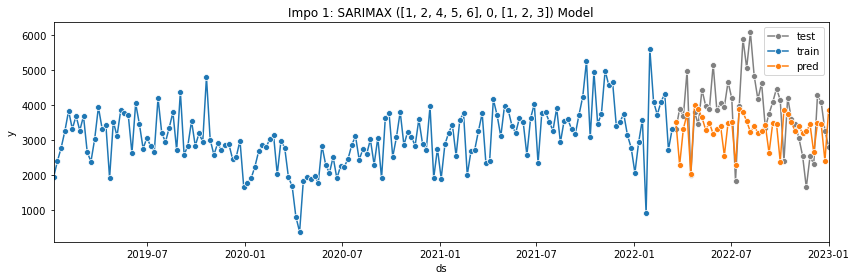

                                            SARIMAX Results                                            
Dep. Variable:                                               y   No. Observations:                  167
Model:             SARIMAX(2, 0, [3, 4, 5])x(1, 1, [1, 2], 12)   Log Likelihood               -1165.370
Date:                                         Sun, 20 Aug 2023   AIC                           2348.740
Time:                                                 20:36:48   BIC                           2376.131
Sample:                                                      0   HQIC                          2359.865
                                                         - 167                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1     

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



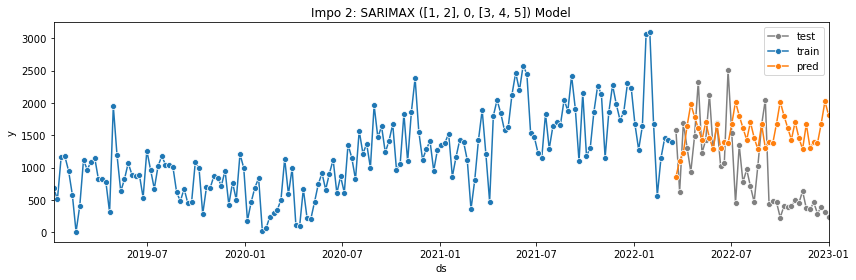

                                        SARIMAX Results                                         
Dep. Variable:                                        y   No. Observations:                  167
Model:             SARIMAX(2, 0, [5])x(2, 1, [1, 2], 9)   Log Likelihood                -897.698
Date:                                  Sun, 20 Aug 2023   AIC                           1811.396
Time:                                          20:36:49   BIC                           1835.897
Sample:                                               0   HQIC                          1821.346
                                                  - 167                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2105      0.074      2.828      0.005       0.065

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



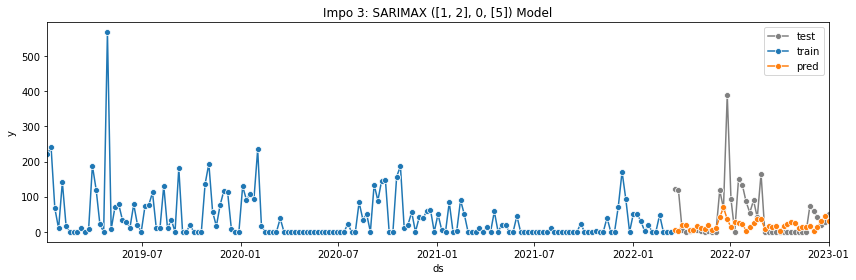

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  167
Model:             SARIMAX([2], 0, 1)x(1, 2, 1, 9)   Log Likelihood               -1026.036
Date:                             Sun, 20 Aug 2023   AIC                           2062.072
Time:                                     20:36:50   BIC                           2077.091
Sample:                                          0   HQIC                          2068.174
                                             - 167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.1247      0.080      1.558      0.119      -0.032       0.282
ma.L1          0.1650      

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



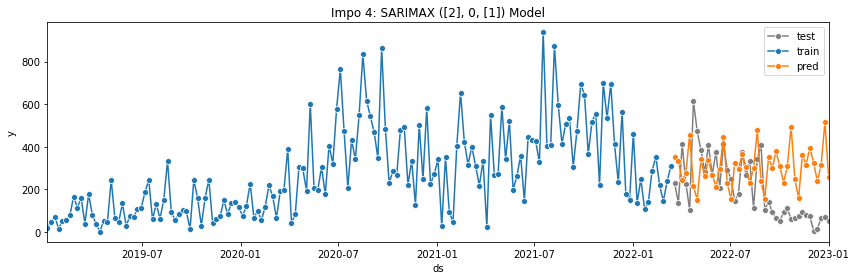

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  167
Model:             SARIMAX([2], 0, [2])x(1, 2, [1, 2], 6)   Log Likelihood               -1164.757
Date:                                    Sun, 20 Aug 2023   AIC                           2341.515
Time:                                            20:36:52   BIC                           2359.775
Sample:                                                 0   HQIC                          2348.932
                                                    - 167                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -1.0000     33.088     -0.030      0

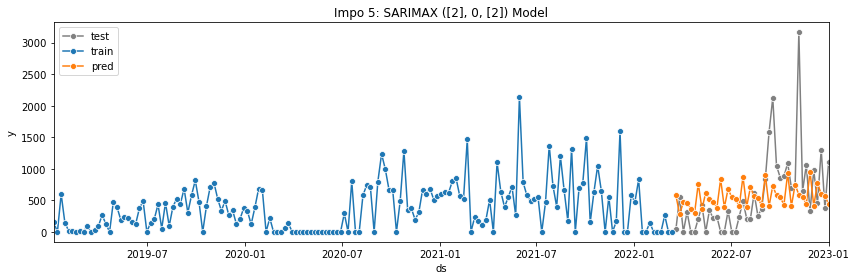

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                   28
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2, 3], 6)   Log Likelihood                -189.901
Date:                                   Sun, 20 Aug 2023   AIC                            393.801
Time:                                           20:36:52   BIC                            403.127
Sample:                                                0   HQIC                           396.652
                                                    - 28                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9219      0.113      8.132      0.000    

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



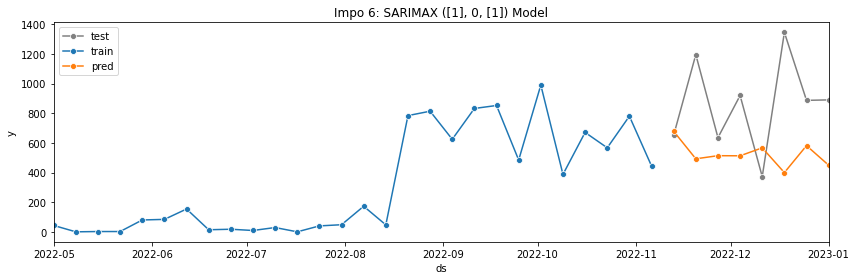

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                                     SARIMAX Results                                                      
Dep. Variable:                                                                  y   No. Observations:                  167
Model:             SARIMAX(2, 0, [10])x(1, 0, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 4)   Log Likelihood               -1059.240
Date:                                                            Sun, 20 Aug 2023   AIC                           2148.479
Time:                                                                    20:36:58   BIC                           2195.249
Sample:                                                                         0   HQIC                          2167.462
                                                                            - 167                                         
Covariance Type:                                                              opg                                         
                

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



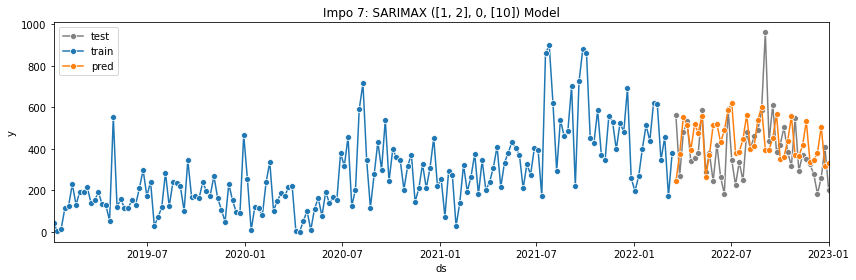

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  167
Model:             SARIMAX([2], 0, 1)x(1, 2, [1, 2], 11)   Log Likelihood               -1310.620
Date:                                   Sun, 20 Aug 2023   AIC                           2633.239
Time:                                           20:37:01   BIC                           2651.100
Sample:                                                0   HQIC                          2640.497
                                                   - 167                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.1410      0.078      1.799      0.072    

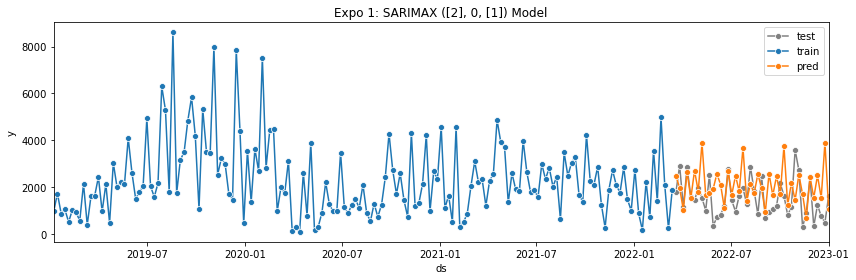

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  166
Model:             SARIMAX([2], 0, 1)x(1, 2, [1, 2], 11)   Log Likelihood               -1205.976
Date:                                   Sun, 20 Aug 2023   AIC                           2423.952
Time:                                           20:37:04   BIC                           2441.770
Sample:                                                0   HQIC                          2431.192
                                                   - 166                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.0384      0.158      0.242      0.808    

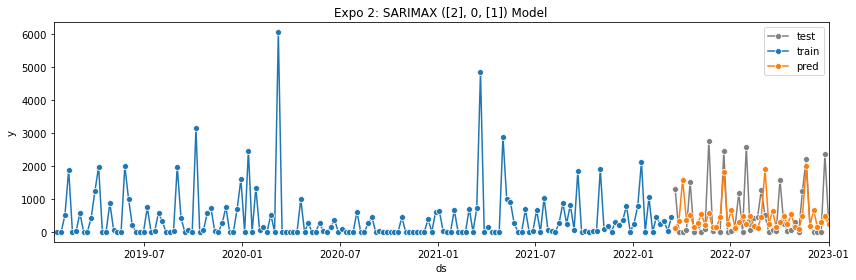

c:\Users\Bravo15\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  164
Model:             SARIMAX([3], 0, 1)x(2, 2, [1, 2], 11)   Log Likelihood                -847.206
Date:                                   Sun, 20 Aug 2023   AIC                           1708.413
Time:                                           20:37:07   BIC                           1729.103
Sample:                                                0   HQIC                          1716.820
                                                   - 164                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L3          0.2031      0.089      2.271      0.023    

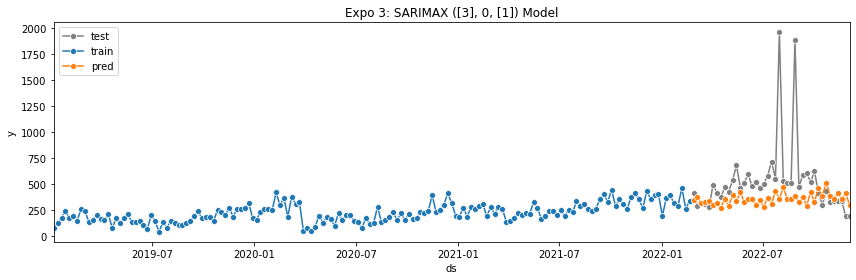

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  167
Model:             SARIMAX(2, 1, [2])x(1, 2, 1, 6)   Log Likelihood               -1031.085
Date:                             Sun, 20 Aug 2023   AIC                           2074.171
Time:                                     20:37:09   BIC                           2092.393
Sample:                                          0   HQIC                          2081.573
                                             - 167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7004      4.522     -0.155      0.877      -9.564       8.163
ar.L2          0.2991      

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_18792\1249350856.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



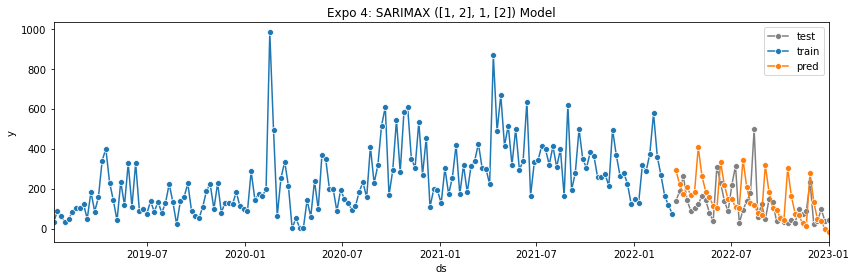

In [214]:
comparison_tbl= sarimax_model(df_impo_1, ([1,2,4,5,6],0,[1,2,3]), (1,1,1,12), 'Impo 1', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_2, ([1,2],0,[3,4,5]),(1,1,2,12), 'Impo 2', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_3, ([1,2],0,[5]),(2,1,2,9), 'Impo 3', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_4, ([2],0,[1]),(1,2,1,9), 'Impo 4', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_5, ([2],0,[2]),(1,2,2,6), 'Impo 5', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_6, ([1],0,[1]),(1,0,3,6), 'Impo 6', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_7, ([1,2],0,[10]),(1,0,10,4), 'Impo 7', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_1, ([2],0,[1]),(1,2,2,11), 'Expo 1', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_2, ([2],0,[1]),(1,2,2,11), 'Expo 2', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_3, ([3],0,[1]),(2,2,2,11), 'Expo 3', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_4, ([1,2],1,[2]),(1,2,1,6), 'Expo 4', comparison_tbl)

Como se puede observar en los resultados obtenidos, utilizando el modelo SARIMAX se puede obtener las variaciones para MA, AR y ARMA. De esta forma, podemos comparar las metricas y los resultados para cada serie. 

In [215]:
comparison_tbl

,Serie,Modelo,MAE,RMSE,MAPE,AIC,Processing Time
0,Impo 1,"SARIMAX ([1, 2, 4, 5, 6], 0, [1, 2, 3])",1022.255649,1277.934403,23.534655,2523.911421,2.2757
0,Impo 2,"SARIMAX ([1, 2], 0, [3, 4, 5])",814.939725,916.49472,170.902148,2348.739857,2.0365
0,Impo 3,"SARIMAX ([1, 2], 0, [5])",42.911631,77.238765,inf,1811.396225,1.5410
0,Impo 4,"SARIMAX ([2], 0, [1])",185.77963,213.952751,335.509116,2062.071743,0.5852
0,Impo 5,"SARIMAX ([2], 0, [2])",414.380749,609.258462,inf,2341.51458,1.2854
0,Impo 6,"SARIMAX ([1], 0, [1])",357.234902,428.275897,41.573802,393.801116,0.3146
0,Impo 7,"SARIMAX ([1, 2], 0, [10])",141.675479,183.709531,37.587186,2148.479475,5.9265
0,Expo 1,"SARIMAX ([2], 0, [1])",1081.536775,1263.645669,106.015978,2633.23941,2.5516
0,Expo 2,"SARIMAX ([2], 0, [1])",668.538533,959.657964,inf,2423.951596,2.7844
0,Expo 3,"SARIMAX ([3], 0, [1])",199.810051,367.548943,32.647749,1708.412602,2.9520
